In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/16h5/s_yaw_16h5_5m_360_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,-41.092977
1,0.872118,-18.993038
2,0.942230,17.051900
3,1.006769,12.351733
4,1.074148,-20.580346
...,...,...
1312,81.375832,51.009816
1313,81.410361,51.009816
1314,81.443139,51.009816
1315,82.043576,-11.602400


<AxesSubplot:xlabel='relative_time'>

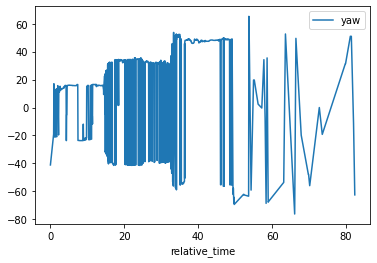

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

170

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

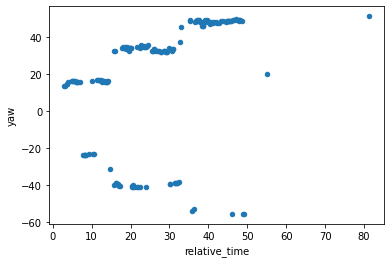

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
30,3.009025,13.592287,45
32,3.142500,13.579817,45
38,3.555130,14.553826,45
40,3.688985,14.486086,45
45,4.024627,15.845328,60
...,...,...,...
1246,48.675626,48.462163,75
1255,48.976492,-55.476148,0
1257,49.046147,-55.455901,0
1278,55.110136,19.718555,60


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
30,3.009025,13.592287,45,31.407713
32,3.142500,13.579817,45,31.420183
45,4.024627,15.845328,60,44.154672
57,4.864436,15.979990,60,44.020010
99,7.740304,-23.548932,15,38.548932
102,7.915005,-23.633410,15,38.633410
293,15.676604,-39.645262,0,39.645262
311,16.243590,-38.680885,0,38.680885
361,17.843506,34.067217,75,40.932783
364,17.943774,34.037041,75,40.962959


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,30.0,42.244398,5.700434,37.963734,38.994470,40.163235,40.947372,55.476148
15,9.0,39.282912,2.716085,37.969676,38.023114,38.621596,38.644479,46.479547
30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,4.0,30.946996,0.539922,30.446174,30.496979,30.960813,31.410830,31.420183
60,50.0,37.071834,8.130576,26.721696,27.780130,43.461906,44.074719,44.322253
75,77.0,31.794995,6.796852,23.970319,26.540350,27.025139,40.605822,41.700067


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

KeyError: 30

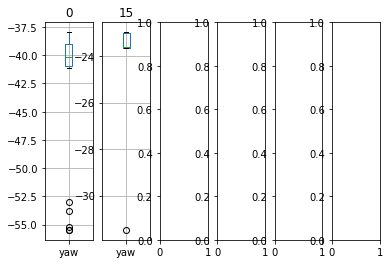

In [16]:
box_plotter(target)

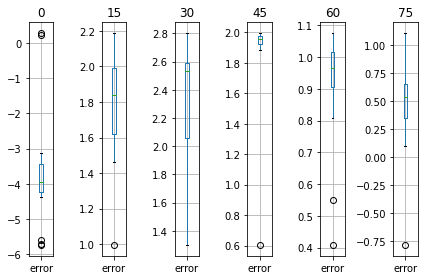

In [ ]:
box_plotter('error')